# This is a pipeline to visualize and analyze the results of CellProfiler on Rabies experiments

In [109]:
%load_ext autoreload
%autoreload 2
import os
from utils import data_reader, plot_utils
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
import matplotlib.pylab as plt
from PIL import Image
from matplotlib import cm


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Select the path where the data is (the output of CellProfiler)
Data_path = '/mnt/c/Users/herny/Desktop/SWC/Data/Microscopy_Data/Rabies_Tracing/ToS-D1_D2/DataForAnalysis/'
# Read it in a useful format
RabiesData, cFosData = data_reader.RabiesCP_data_reader(Data_path + 'CellProfilerOutput/')

In [197]:
cFosData.BrainSide

0       Contra
1       Contra
2       Contra
3       Contra
4       Contra
5       Contra
6       Contra
7       Contra
8       Contra
9       Contra
10      Contra
11      Contra
12      Contra
13      Contra
14      Contra
15      Contra
16      Contra
17      Contra
18      Contra
19      Contra
20      Contra
21      Contra
22      Contra
23      Contra
24      Contra
25      Contra
26      Contra
27      Contra
28      Contra
29      Contra
         ...  
8003      Ipsi
8004      Ipsi
8005      Ipsi
8006      Ipsi
8007      Ipsi
8008      Ipsi
8009      Ipsi
8010      Ipsi
8011      Ipsi
8012      Ipsi
8013      Ipsi
8014      Ipsi
8015      Ipsi
8016      Ipsi
8017      Ipsi
8018      Ipsi
8019      Ipsi
8020      Ipsi
8021      Ipsi
8022      Ipsi
8023      Ipsi
8024      Ipsi
8025      Ipsi
8026      Ipsi
8027      Ipsi
8028      Ipsi
8029      Ipsi
8030      Ipsi
8031      Ipsi
8032      Ipsi
Name: BrainSide, Length: 8033, dtype: object

/home/hmvergara/anaconda3/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


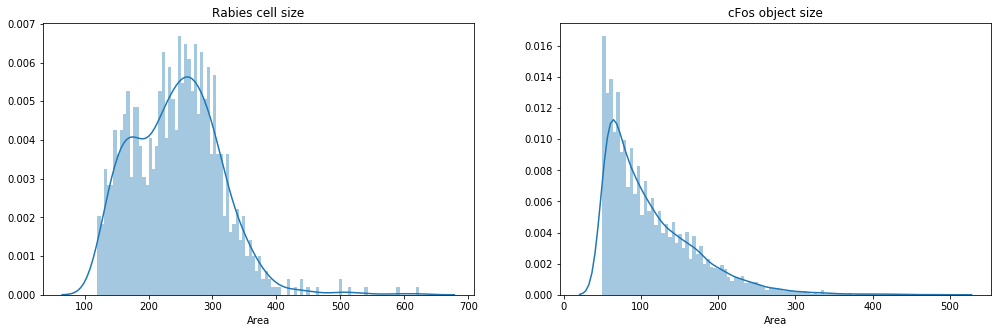

In [173]:
# cell area size
fig, axs = plt.subplots(1,2, figsize=(17,5))
axs = axs.ravel()
sns.distplot(RabiesData.Area, bins=100, ax = axs[0])
axs[0].set_title('Rabies cell size')
sns.distplot(cFosData.Area, bins=100, ax = axs[1])
axs[1].set_title('cFos object size')
plt.show()

In [163]:
# filter by size
RabiesDataSF = RabiesData[RabiesData['Area']>200]
cFosDataSF = cFosData

In [199]:
# filter by side of the brain
RabiesDataSF = RabiesDataSF[RabiesDataSF['BrainSide']=='Ipsi']
cFosDataSF = cFosDataSF[cFosDataSF['BrainSide']=='Ipsi']

In [164]:
percCol = 'cFosPercentile_98_Object'

TotalRabiesD1 = len(RabiesDataSF[RabiesDataSF['StarterCells']=='D1'])
TotalRabiesD2 = len(RabiesDataSF[RabiesDataSF['StarterCells']=='D2'])
TotalcFosD1 = len(cFosDataSF[np.logical_and(cFosDataSF['StarterCells']=='D1', cFosDataSF['PercentileInfo']==percCol)])
TotalcFosD2 = len(cFosDataSF[np.logical_and(cFosDataSF['StarterCells']=='D2', cFosDataSF['PercentileInfo']==percCol)])
TotalRabiesAndcfosD1 = len(RabiesDataSF[np.logical_and(RabiesDataSF[percCol]!=0, RabiesDataSF['StarterCells']=='D1')])
TotalRabiesAndcfosD2 = len(RabiesDataSF[np.logical_and(RabiesDataSF[percCol]!=0, RabiesDataSF['StarterCells']=='D2')])


print('Total rabies cells:')
print('D1: ',str(TotalRabiesD1))
print('D2: ',str(TotalRabiesD2))


print('\nTotal c-Fos objects:')
print('D1: ',str(TotalcFosD1))
print('D2: ',str(TotalcFosD2))


print('\nOverlap of rabies and c-Fos:')
print('D1: ',str(100 * TotalRabiesAndcfosD1 / (TotalcFosD1 + TotalRabiesD1)))
print('D2: ',str(100 * TotalRabiesAndcfosD2 / (TotalcFosD2 + TotalRabiesD2)))


Total rabies cells:
D1:  166
D2:  532

Total c-Fos objects:
D1:  488
D2:  1772

Overlap of rabies and c-Fos:
D1:  2.599388379204893
D2:  2.907986111111111


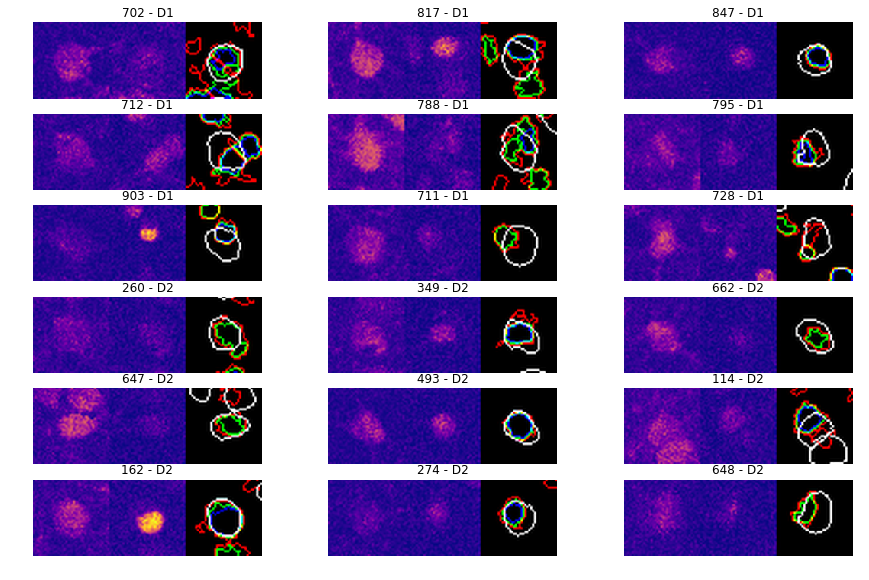

In [166]:
# explore the dataset, plotting a random subset of cells
NumOfSamples = 18
# get the indexes of d1 and d2 cohorts
d1shuffledIdx = RabiesDataSF[np.logical_and(RabiesDataSF[percCol]!=0, RabiesDataSF['StarterCells']=='D1')].index.values
d2shuffledIdx = RabiesDataSF[np.logical_and(RabiesDataSF[percCol]!=0, RabiesDataSF['StarterCells']=='D2')].index.values
# shuffle them
np.random.shuffle(d1shuffledIdx)
np.random.shuffle(d2shuffledIdx)
IdxToPlot = list(d1shuffledIdx[0:int(NumOfSamples/2)]) + list(d2shuffledIdx[0:int(NumOfSamples/2)])
fig = plt.subplots(sharey=False, figsize=(15,30))
for counter,i in enumerate(IdxToPlot): # make random without reinsertion
    # write here the cell number
    CellImage = plot_utils.plotRabiesCell(RabiesData.iloc[i], Data_path, window=20, lut='plasma')
    plt.subplot(NumOfSamples, 3, counter+1)
    plt.grid(False)
    plt.axis('off')
    plt.title(str(i) + " - " + RabiesData.iloc[i]['StarterCells'])
    plt.imshow(CellImage)




In [ ]:
# Check and maybe filter different parameters